In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from cartoplot import cartoplot
import itertools
from scipy.stats import linregress
import tqdm

In [2]:
data_dir = '/home/robbie/Dropbox/SM_Thickness/data/SnowModel/monthly_means/361'

d = Dataset(f'{data_dir}/200010.nc')

In [3]:
def make_stack(month):

    if int(month)>8: first_year = 1980; last_year = 2019
    else: first_year = 1981; last_year = 2020
    
    years = np.arange(first_year,last_year)

    depth_stack = np.full((years.shape[0],361,361), np.nan)

    for year in years:

        d = Dataset(f'{data_dir}/{year}{month}.nc')

        depth_stack[year-years[0]] = np.array(d['M2 depth'])
        
    return depth_stack


stacks = {'10':make_stack('10'),
          '04':make_stack('04')}
    
#     break
    


/tmp/ipykernel_11064/1168030408.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  depth_stack[year-years[0]] = np.array(d['M2 depth'])


In [36]:
np.count_nonzero(~np.isnan(depth_series))

0

In [37]:
output = {}

for month in ['10','04']:

    trends = np.full((361,361), np.nan)
    signifs = np.full((361,361), np.nan)

    for i, j in tqdm.tqdm(itertools.product(np.arange(361),
                                            np.arange(361))):

        depth_series = stacks[month][:,i,j]
        time_series = np.arange(depth_series.shape[0])

        if np.count_nonzero(~np.isnan(depth_series))<5:
            slope, pval = np.nan, np.nan
        else:
            
            clean_depths = depth_series[~np.isnan(depth_series)]
            clean_times = time_series[~np.isnan(depth_series)]

            regression = linregress(clean_times,clean_depths)

            slope, pval = regression[0], regression[3]

        trends[i,j] = slope*10*100 # cm per decade
        signifs[i,j] = pval

    signifs[signifs<0.05] = 1
#     signifs[signifs!=1] = 0

    signif_trends = trends.copy()
    signif_trends[signifs!=1] = np.nan
    
    
    output[month] = {'trends':trends,
                     'signif_trends':signif_trends,
                     'signifs':signifs}
    
#     break

130321it [00:03, 43117.02it/s]
130321it [00:04, 27711.99it/s]


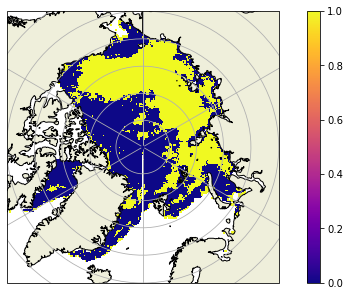

In [23]:
s = signifs.copy()

s[s<1] = 0

cartoplot(d['lon'],d['lat'],s)

In [17]:
import cartopy.crs as ccrs
import cartopy

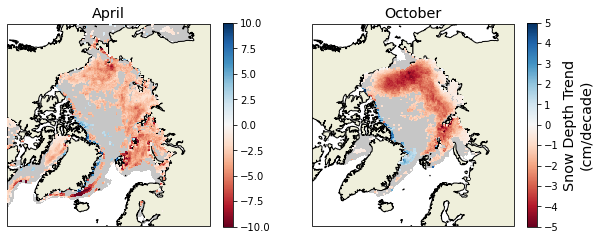

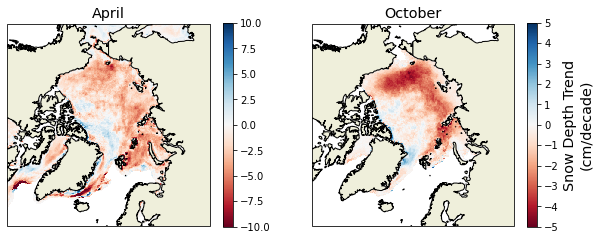

In [40]:
def make_figs(grayshade,save):

    fig, axs = plt.subplots(1,2,figsize=(10,5),subplot_kw={'projection':ccrs.NorthPolarStereo()})

    for month, ax in zip(['04','10'],axs):

        if month == '04':
            lims = (-10,10)
            mname = 'April'
        else:
            lims = (-5,5)
            mname = 'October'

        ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
        ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

        if grayshade:
            
            sigs = output[month]['signifs'].copy()
            sigs[sigs<1] = 0
            sigs[sigs>0] = np.nan
            
            mesh = ax.pcolormesh(d['lon'], d['lat'], output[month]['signif_trends'][:-1,:-1], vmin = lims[0], vmax = lims[1],
                         transform=ccrs.PlateCarree(),cmap='RdBu',zorder=5)
            
            grey = ax.pcolormesh(d['lon'], d['lat'], sigs[:-1,:-1], vmin = -2, vmax = 1,
                         transform=ccrs.PlateCarree(),zorder=0,cmap='Greys_r')

        else:
            mesh = ax.pcolormesh(d['lon'], d['lat'], output[month]['trends'][:-1,:-1], vmin = lims[0], vmax = lims[1],
                         transform=ccrs.PlateCarree(),zorder=0,cmap='RdBu')

        cb = plt.colorbar(mesh,ax=ax,shrink=0.75)

        if month =='10':
            cb.set_label('Snow Depth Trend\n(cm/decade)',fontsize='x-large')

        if month == '10':
            tix = cb.get_ticks()
            cb.set_ticks(np.arange(-5,6))

        ax.set_title(mname,fontsize='x-large')

        if save:
            plt.savefig(f'SM_trends_grey_{grayshade}.jpg', bbox_inches='tight',dpi=500)
            
            
make_figs(grayshade=True,save=True)
make_figs(grayshade=False,save=True)

In [ ]:
cb.get_ticks()

In [ ]:
for month in ['04','10']:

    cartoplot(d['lon'],d['lat'],output[month]['trends'][:-1,:-1],vmin=-5,vmax=5, cmap='RdBu',)
    cartoplot(d['lon'],d['lat'],output[month]['signif_trends'][:-1,:-1],vmin=-5,vmax=5, cmap='RdBu',)
#     cartoplot(d['lon'],d['lat'],output[month]['signifs'][:-1,:-1],vmin=-0,vmax=1, cmap='plasma',)